Setup and Project Root & Import Libraries

In [1]:
import sys, os
# ==== Set Project Root ====
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(project_root)

# Ensure the model save directory exists
model_save_path = os.path.join(project_root, 'Models', 'Weights', 'GRU')
os.makedirs(model_save_path, exist_ok=True)

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from Models.GRU import GRUModel  # Assuming GRU model is defined in Models/GRU.py
from Training.Helper.PyTorchModular import optuna_tune_and_train, split_params  # Import Optuna function
from Training.Helper.dataPreprocessing import create_sequences, add_lagged_features, add_rolling_features, add_time_features, add_dimension, TRAIN_DATA_SPLIT
from Evaluation.Helper.evaluation_helpers import calc_metrics_arrays, make_evaluation_predictions


Load and Prepare Data & Feature Engineering

In [2]:
# ==== Load & Prepare CSV ====
train_file = os.path.join(project_root, "Data", "Train", "train1990s.csv")
df = pd.read_csv(train_file)
df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
df = df.rename(columns={'fred_PCEPI': 'y'})


# ==== Feature Engineering ====

# Adding time-based features
df = add_time_features(df, date_col='ds')

# Adding sine and cosine monthly features of various wavelengths (seasonality features)
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['month'] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['month'] / 12)

# Adding lag features
df = add_lagged_features(df, target_cols=['y'], lags=[1, 3, 6])

# Adding rolling features
df = add_rolling_features(df, target_col='y', windows=[3, 6, 12])

df = df.dropna().reset_index(drop=True)


2025-04-15 12:16:51,175 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)
2025-04-15 12:16:51,182 - INFO - Added lagged features with lags [1, 3, 6] to target columns ['y']. DataFrame shape: (408, 372)
2025-04-15 12:16:51,186 - INFO - Added rolling mean and standard deviation features to target column y. DataFrame shape: (408, 378)


Scaling and Sequence Preparation & DataLoaders

In [3]:
# ==== Scaling ====
feature_cols = ['y'] + [col for col in df.columns if col.startswith(('sin_', 'cos_', 'y_lag_', 'rolling_'))]
scaler = StandardScaler()

scaled = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols)

# ==== Sequence Prep ====
sequence_length = 12
X, y = create_sequences(
    scaled_df[feature_cols].values,
    scaled_df['y'].values,
    sequence_length
)
X = X.reshape((-1, sequence_length, len(feature_cols)))
y = add_dimension(y)

# ==== Train/Val Split ====
split_idx = int(TRAIN_DATA_SPLIT * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# ==== DataLoaders ====
batch_size = 32
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Set Device and Train with Optuna & Prediction Logic

In [4]:
# ==== Device & Save Path ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(model_save_path, exist_ok=True)

# ==== Use optuna_tune_and_train from PyTorchModular ====
#best_model, best_params = optuna_tune_and_train(
#    model_class=GRUModel,  # Pass the model class (GRUModel in this case)
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    input_size=len(feature_cols), # Pass input_size dynamically based on the number of features
#    max_epochs=50,  # Number of epochs
#    model_save_path=model_save_path,
#    model_name="GRU_exog_Optuna",  # Model name for saving
#    n_trials=30,  # Number of Optuna trials
#    verbose=False  # Print progress
#)

model_invariates = {'input_size': len(feature_cols), 'output_size': 1}
model_search_space={"hidden_size": (int, (32, 256)), "num_layers": (int, (1, 4))}
optim_search_space={"lr": (float, (1e-5, 1e-1))}

best_model, metadata, study = optuna_tune_and_train(
    model_class=GRUModel, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device,
    model_search_space=model_search_space,
    # Pass input_size dynamically based on the number of features
    model_invariates=model_invariates,
    optim_search_space=optim_search_space,
    max_epochs=50,
    model_save_path=model_save_path,
    model_name="GRU_exog_Optuna",
    n_trials=30,
    return_study=True,
    verbose=True
)

print("Training completed. Best hyperparameters:", study.best_params)

best_model_params, best_optimiser_params = split_params(study.best_params, model_search_space, optim_search_space)


# ==== Prediction Logic ====

# Function to load the model for inference
def load_model(model_save_path, model_invariates, best_model_params, device):
    best_model_path = os.path.join(model_save_path, "GRU_exog_Optuna_best.pth")
    best_model = GRUModel(**model_invariates, **best_model_params).to(device)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()
    return best_model

# Function to make predictions and inverse transform results
def make_predictions(model, X_val, y_val, scaler, feature_cols, device):
    with torch.no_grad():
        y_pred = model(torch.tensor(X_val).float().to(device)).squeeze().cpu().numpy()

    # Inverse transform results
    y_val_original = scaler.inverse_transform(
        np.hstack([y_val.reshape(-1, 1), np.zeros((len(y_val), len(feature_cols)-1))])
    )[:, 0]

    y_pred_original = scaler.inverse_transform(
        np.hstack([y_pred.reshape(-1, 1), np.zeros((len(y_pred), len(feature_cols)-1))])
    )[:, 0]
    
    return y_val_original, y_pred_original

[I 2025-04-15 12:16:51,239] A new study created in memory with name: GRU_exog_Optuna_hyperparameter_optimisation


Running Optuna hyperparameter tuning...


[I 2025-04-15 12:16:57,898] Trial 0 finished with value: 1.4602183242896936 and parameters: {'hidden_size': 218, 'num_layers': 3, 'lr': 0.04888332583074115}. Best is trial 0 with value: 1.4602183242896936.
[I 2025-04-15 12:17:01,728] Trial 1 finished with value: 0.8360195872071502 and parameters: {'hidden_size': 106, 'num_layers': 4, 'lr': 0.05968982015929966}. Best is trial 1 with value: 0.8360195872071502.
[I 2025-04-15 12:17:04,037] Trial 2 finished with value: 0.6604519943138222 and parameters: {'hidden_size': 72, 'num_layers': 3, 'lr': 0.062108916270227736}. Best is trial 2 with value: 0.6604519943138222.
[I 2025-04-15 12:17:06,845] Trial 3 pruned. 
[I 2025-04-15 12:17:09,116] Trial 4 finished with value: 0.3705237763268607 and parameters: {'hidden_size': 67, 'num_layers': 3, 'lr': 0.03784785434564816}. Best is trial 4 with value: 0.3705237763268607.
[I 2025-04-15 12:17:11,757] Trial 5 finished with value: 0.3500376676584219 and parameters: {'hidden_size': 37, 'num_layers': 4, 'lr

Best hyperparameters found: {'hidden_size': 174, 'num_layers': 1, 'lr': 0.006809665134705732}


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.173992, Val Loss: 0.373919
Best model saved at c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_exog_Optuna_BEST_STOPPED_AT_1.pth (Epoch 1)
Epoch 2/50 - Train Loss: 0.017853, Val Loss: 0.016808
Best model saved at c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_exog_Optuna_BEST_STOPPED_AT_2.pth (Epoch 2)
Epoch 3/50 - Train Loss: 0.006545, Val Loss: 0.042206
Epoch 4/50 - Train Loss: 0.001621, Val Loss: 0.027730
Epoch 5/50 - Train Loss: 0.000813, Val Loss: 0.026658
Epoch 6/50 - Train Loss: 0.000527, Val Loss: 0.030485
Epoch 7/50 - Train Loss: 0.000373, Val Loss: 0.026964
Epoch 8/50 - Train Loss: 0.000336, Val Loss: 0.027031
Epoch 9/50 - Train Loss: 0.000356, Val Loss: 0.022902
Epoch 10/50 - Train Loss: 0.000451, Val Loss: 0.026700
Epoch 11/50 - Train Loss: 0.000417, Val Loss: 0.019283
Epoch 12/50 - Train Loss: 0.000345, Val Loss: 0.024105
Epoch 13/50 - Train Loss:

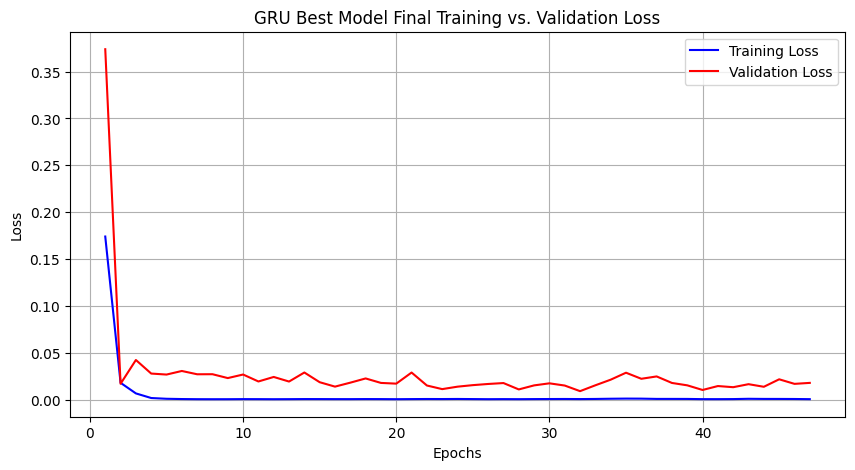

In [5]:
from Training.Helper.PyTorchModular import loss_curve

# An interesting consideration - look at a graph showing the loss stats over time for the final training run
loss_curve(metadata['trainLoss'], metadata['validLoss'], 'GRU Best Model Final Training vs. Validation Loss')

RMSE and Saving Predictions & Main Execution Function

In [9]:
# Function to trim the last N values of predictions and save the file
def trim_and_save_predictions(predictions_path, n_trim=48):
    gru_preds = np.load(predictions_path)
    gru_preds_trimmed = gru_preds[-n_trim:]
    np.save(predictions_path, gru_preds_trimmed)
    print(f"Trimmed GRU_exog.npy to {len(gru_preds_trimmed)} values and saved.")

# Main execution function for predictions
def main(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root):
    # Load the trained model
    model = load_model(model_save_path, model_invariates, best_model_params, device)

    # Make predictions and inverse transform
    y_pred_original, y_val_original = make_evaluation_predictions(model, val_loader, device=device, y_scaler=scaler, y_scaler_features=['y'])
    
    # Calculate metrics (change from default using 'metrics' keyword in calc_metrics_kwargs)
    metrics = calc_metrics_arrays(y_val_original,  y_pred_original, model_names=['GRU'])
    display(metrics)

    # Save predictions to GRU.npy
    pred_save_path = os.path.join(project_root, "Predictions", "GRU.npy")
    np.save(pred_save_path, y_pred_original)

    # Trim the last 48 values from the predictions and save
    trim_and_save_predictions(pred_save_path, n_trim=48)

# Assuming these variables are already defined: model_save_path, best_params, val_loader, scaler, feature_cols, device, project_root
main(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root)

,RMSE,MAE,r2
GRU,1.48356,1.110716,0.955593


Trimmed GRU_exog.npy to 48 values and saved.


In [ ]:
# In case this is found useful

#from Training.Helper.weightFileCleaner import cleanWeightFiles

#cleanWeightFiles('GRU_exog_optuna', dirPath=model_save_path, verbose=True)

Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_1.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_16.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_2.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_22.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_31.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_inflation_BEST_STOPPED_AT_6.pth
Removed file at: c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\GRU\GRU_